In [37]:
!pip install transformers datasets accelerate torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
/kaggle/input/jigsaw-agile-community-rules/train.csv
/kaggle/input/jigsaw-agile-community-rules/test.csv


In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [40]:
# Initialize accelerate state
from accelerate import PartialState
distributed_state = PartialState()

In [41]:
# Load data
train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
test_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')

# Combine text fields for each sample
def combine_text_fields(row):
    return f"Comment: {row['body']}\nRule: {row['rule']}\nPositive Example 1: {row['positive_example_1']}\nPositive Example 2: {row['positive_example_2']}\nNegative Example 1: {row['negative_example_1']}\nNegative Example 2: {row['negative_example_2']}"

train_df['combined_text'] = train_df.apply(combine_text_fields, axis=1)
test_df['combined_text'] = test_df.apply(combine_text_fields, axis=1)

# Split training data for validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['combined_text'].tolist(),
    train_df['rule_violation'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['rule_violation']
)

In [42]:
class RedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [43]:
# Initialize ModernBERT tokenizer and model
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,  # Binary classification
    problem_type="regression"  # For BCEWithLogitsLoss
)

# Create datasets
train_dataset = RedditDataset(train_texts, train_labels, tokenizer)
val_dataset = RedditDataset(val_texts, val_labels, tokenizer)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    auc = roc_auc_score(labels, probs)
    return {"auc": auc}

In [45]:
# Set up training arguments with disabled mixed precision
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="auc",
    greater_is_better=True,
    report_to="none",
    fp16=False,
    bf16=False,  
)

In [46]:
# Fixed CustomTrainer
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_losses = []
        self.validation_losses = []
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Compute BCE loss
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
        
        # Store training loss
        self.training_losses.append(loss.item())
        
        return (loss, outputs) if return_outputs else loss
    
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        # Run evaluation
        eval_output = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        
        # Store validation loss
        if "eval_loss" in eval_output:
            self.validation_losses.append(eval_output["eval_loss"])
        
        return eval_output

In [47]:
# Initialize custom trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/tmp/ipykernel_36/4238308739.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [48]:
# Train the model
trainer.train()

# Get the losses
train_losses = trainer.training_losses
val_losses = trainer.validation_losses

Epoch,Training Loss,Validation Loss,Auc
1,0.724900,0.699046,0.623058
2,0.663600,0.632542,0.741675
3,0.554000,0.519542,0.830777


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

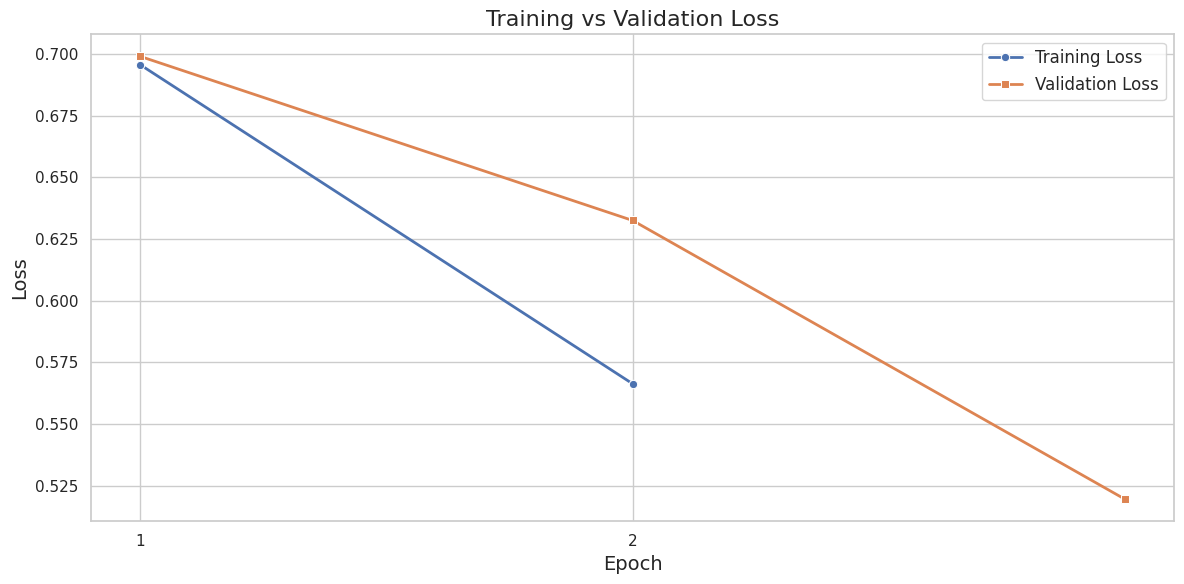

In [49]:
# Plot losses
def plot_losses(train_losses, val_losses):
    # Group training losses by epoch
    epoch_length = len(train_dataset) // training_args.per_device_train_batch_size
    train_losses_per_epoch = [train_losses[i:i+epoch_length] for i in range(0, len(train_losses), epoch_length)]
    avg_train_losses = [np.mean(epoch_losses) for epoch_losses in train_losses_per_epoch]
    
    # Create plot
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    # Plot training loss
    sns.lineplot(x=range(1, len(avg_train_losses)+1), y=avg_train_losses, 
                 label='Training Loss', marker='o', linewidth=2)
    
    # Plot validation loss
    sns.lineplot(x=range(1, len(val_losses)+1), y=val_losses, 
                 label='Validation Loss', marker='s', linewidth=2)
    
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(range(1, len(avg_train_losses)+1))
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

In [50]:
# Analyze model performance
def analyze_model_performance(train_losses, val_losses):
    # Calculate average losses
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    
    # Calculate loss difference
    loss_diff = avg_val_loss - avg_train_loss
    
    print(f"Average Training Loss: {avg_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Loss Difference (Val - Train): {loss_diff:.4f}")
    
    # Analyze model behavior
    if loss_diff > 0.1:
        if avg_train_loss < 0.3:
            print("\nModel Status: POTENTIAL OVERFITTING")
            print("Recommendations: Increase regularization, add dropout, reduce model complexity")
        else:
            print("\nModel Status: UNDERFITTING")
            print("Recommendations: Increase model capacity, train longer, reduce regularization")
    else:
        if avg_train_loss < 0.3:
            print("\nModel Status: GOOD FIT")
            print("Recommendations: Continue monitoring, consider early stopping")
        else:
            print("\nModel Status: UNDERFITTING")
            print("Recommendations: Increase model capacity, train longer")

# Analyze the model
analyze_model_performance(train_losses, val_losses)

Average Training Loss: 0.6420
Average Validation Loss: 0.6170
Loss Difference (Val - Train): -0.0250

Model Status: UNDERFITTING
Recommendations: Increase model capacity, train longer


In [52]:
# Create test dataset without labels for prediction
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
        }

In [53]:
# Create test dataset without labels
test_dataset = TestDataset(test_df['combined_text'].tolist(), tokenizer)

# Custom prediction function
def predict_with_model(model, test_dataset, batch_size=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    all_predictions = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            probs = torch.sigmoid(logits).cpu().numpy()
            all_predictions.extend(probs.flatten())
    
    return all_predictions

# Get predictions
predictions = predict_with_model(model, test_dataset)

Predicting: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


In [54]:
# Create submission file
submission = pd.DataFrame({
    'row_id': test_df['row_id'],
    'rule_violation': predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!
